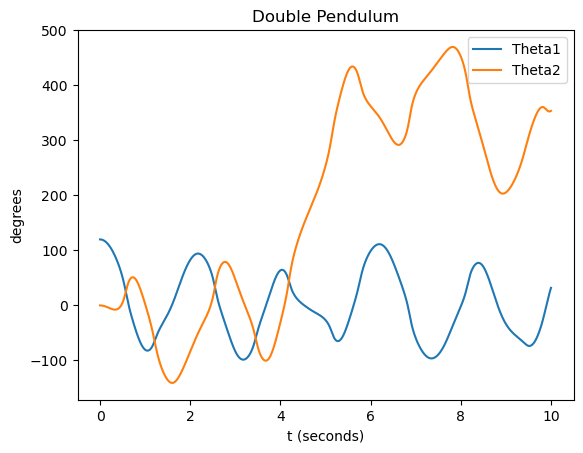

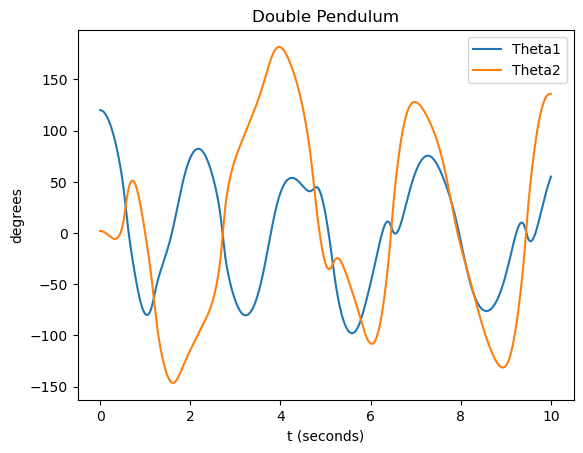

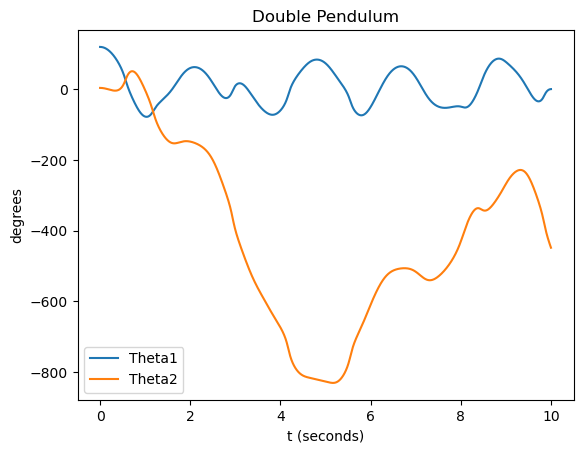

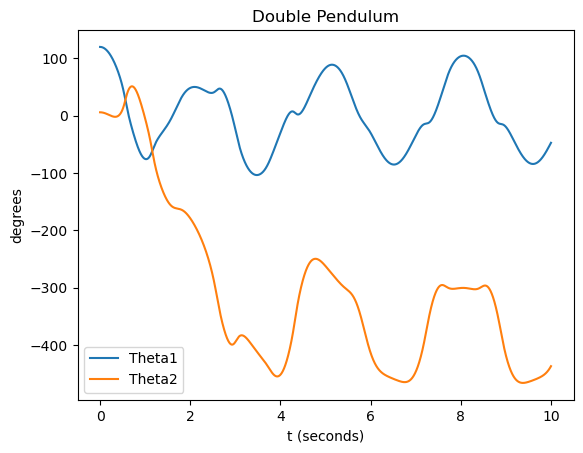

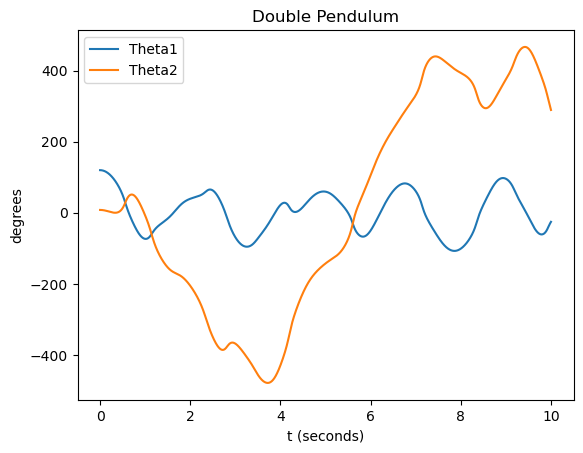

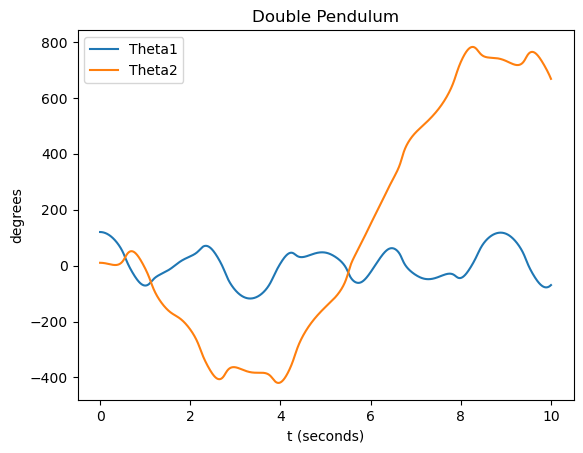

Final RMSE: 0.27196262478493105
Final R^2 Score: -0.07321671836098859


ValueError: x and y must have same first dimension, but have shapes (2000,) and (12000,)

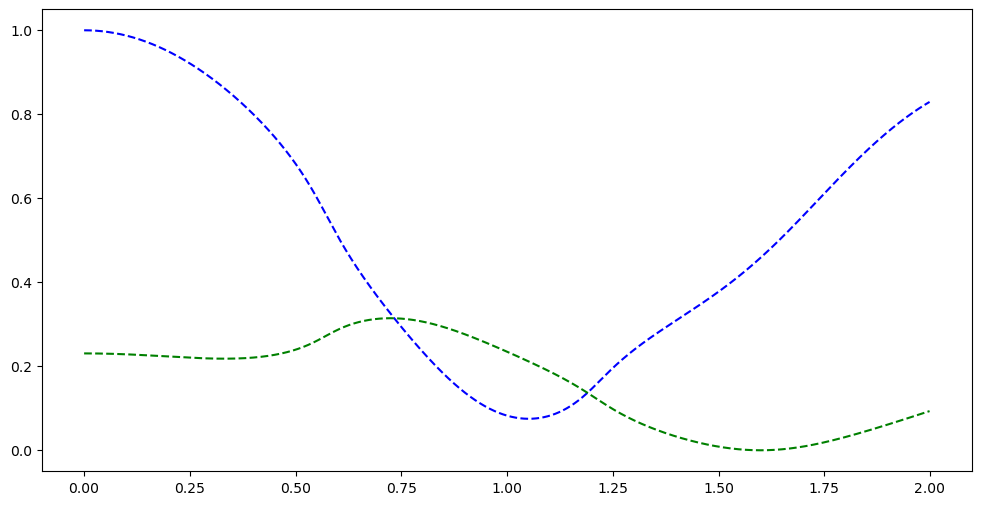

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Double Pendulum Parameters
g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

# Function for Double Pendulum System using Runge-Kutta
def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2) - 2 * sin(theta1 - theta2) * m2 *
               (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1) + omega2**2 * L2 * m2 *
                                           cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return np.array([ftheta1, fomega1, ftheta2, fomega2], float)

# Simulation Parameters for the Runge-Kutta method
a = 0.0
b = 10
N = 10000
h = (b - a) / N

# List of initial conditions
angles = [[120, 0], [120, 2], [120, 4], [120, 6], [120, 8], [120, 10]]

for x in angles:
    tpoints = np.arange(a, b, h)
    theta1_points = np.zeros_like(tpoints)
    theta2_points = np.zeros_like(tpoints)

    q = np.array([x[0] * pi / 180, 0, x[1] * pi / 180, 0], float)

    for i, t in enumerate(tpoints):
        theta1_points[i] = q[0] * 180 / pi
        theta2_points[i] = q[2] * 180 / pi

        k1 = h * f(q, t, L1, L2)
        k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
        k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
        k4 = h * f(q + k3, t + h, L1, L2)
        q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    plt.plot(tpoints, theta1_points, label='Theta1')
    plt.plot(tpoints, theta2_points, label='Theta2')
    plt.title("Double Pendulum")
    plt.xlabel("t (seconds)")
    plt.ylabel("degrees")
    plt.legend()
    plt.show()

    data = np.stack((theta1_points, theta2_points), axis=1)
    np.save(f'pendulum_data_{str(x[0])}_{str(x[1])}.npy', data)

# Data processing and preparation for Random Forest
data = {}
for i in angles:
    loaded_data = np.load(f'pendulum_data_{str(i[0])}_{str(i[1])}.npy')
    scaler = MinMaxScaler()
    data_ = scaler.fit_transform(loaded_data)
    data[f'{str(i[0])}_{str(i[1])}'] = data_

def create_io(data):
    x, x_1, x_2, y_1, y_2 = [], [], [], [], []
    for starting in data:
        starting_theta_1_degrees = int(starting.split("_")[0])
        starting_theta_2_degrees = int(starting.split("_")[1])

        starting_theta_1 = starting_theta_1_degrees * pi / 180
        starting_theta_2 = starting_theta_2_degrees * pi / 180

        angle_data = data[starting]
        for i in range(len(angle_data)):
            x.append(tpoints[i])
            x_1.append(starting_theta_1)
            x_2.append(starting_theta_2)
            y_1.append(angle_data[i][0])
            y_2.append(angle_data[i][1])
    return x, x_1, x_2, y_1, y_2

x, x_1, x_2, y_1, y_2 = create_io(data)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_combined = np.vstack([x_1, x_2, x]).T
x_scaled = scaler_x.fit_transform(x_combined)

y_combined = np.vstack([y_1, y_2]).T
y_scaled = scaler_y.fit_transform(y_combined)

# Split data into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(x_scaled))
x_train, y_train = x_scaled[:train_size], y_scaled[:train_size]
x_test, y_test = x_scaled[train_size:], y_scaled[train_size:]

# Define the Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
random_forest.fit(x_train, y_train)

# Make predictions on test data
y_pred_scaled = random_forest.predict(x_test)

# Inverse transform predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test)

# RMSE and R^2 scores
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Final RMSE: {rmse}")
print(f"Final R^2 Score: {r2}")

# Plotting results for the test set
plt.figure(figsize=(12, 6))
plt.plot(x[0:2000], y_1[0:2000], label='True y_1', color='blue', linestyle='--')
plt.plot(x[0:2000], y_2[0:2000], label='True y_2', color='green', linestyle='--')
plt.plot(x[0:2000], y_pred[:, 0], label='Predicted y_1', color='red')
plt.plot(x[0:2000], y_pred[:, 1], label='Predicted y_2', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Comparison of True and Predicted Angles for Double Pendulum (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()
